In [35]:
import MDAnalysis as mda
import freud
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.interpolate import CubicSpline

In [36]:
def get_max_nematic_order(top_file, traj_file):

    u = mda.Universe(top_file, format="DATA", atom_style="id resid type charge x y z")
    u.load_new(traj_file, format="LAMMPSDUMP", dt=1.0)

    nematic = freud.order.Nematic()

    S_lst = []

    for frame_id, frame in enumerate(u.trajectory):

        if frame_id < 100:
            continue

        mol_positions = []
        for mol in u.residues:
            if len(mol.atoms) == 12:
                mol_positions.append(mol.atoms.positions.copy())

        box_dims = u.dimensions[:3]
        for i, mol in enumerate(mol_positions):
            ref = mol[0]
            delta = mol - ref
            delta = delta - box_dims * np.round(delta/box_dims)
            mol_positions[i] = ref + delta

        orientations = []
        for mol in mol_positions:
            head = mol[0]
            tail = (mol[7] + mol[11]) / 2
            vec = tail - head
            orientations.append(vec / np.linalg.norm(vec))

        nematic.compute(np.array(orientations))
        S = nematic.order

        S_lst.append(S)

    max_S = np.max(S_lst)
    max_frame = np.argmax(S_lst)
    mean_S = np.mean(S_lst)
    std_S = np.std(S_lst)


    return max_S, max_frame, mean_S, std_S


In [37]:
dir = "/home/gabriel/Dokumente/bachelor_thesis/dpd_simulation/lipid_self_assembly/"

apls_str = ["05", "055", "06", "065", "07", "075", "08", "085", "0875", "09", "095", "1", "105", "11", "115", "12"]

trajectories = []

for apl in apls_str:
    trajectories.append((f"setup/bilayers/bilayer_{apl}.data", f"apl_opt/trajs/bilayer_{apl}.lammpstrj"))

In [38]:
results = []

for top, traj in trajectories:
    top_path = os.path.join(dir, top)
    traj_path = os.path.join(dir, traj)

    max_S, max_frame, mean_S, std_S = get_max_nematic_order(top_path, traj_path)

    results.append((max_S, mean_S, std_S))

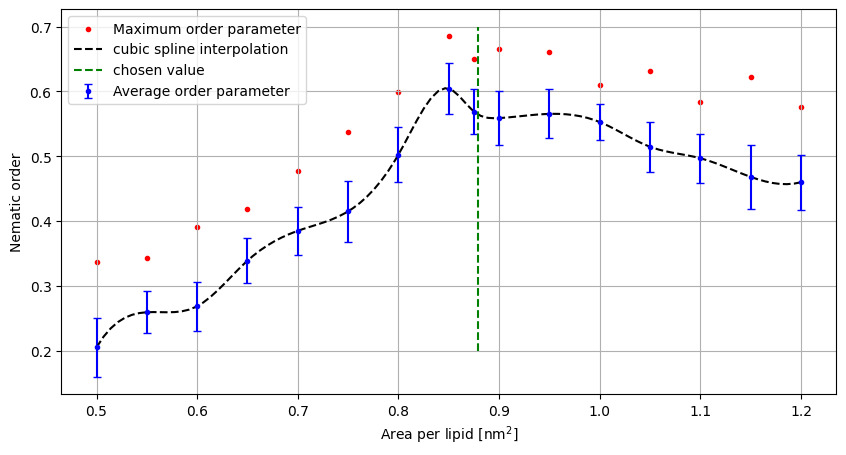

In [39]:
apls = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.875, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2]

mean = [t[1] for t in results]
max = [t[0] for t in results]
std = [t[2] for t in results]

spline = CubicSpline(apls, mean)
range = np.linspace(0.5,1.2,100)

plt.figure(figsize=(10,5))
plt.scatter(apls, max, marker=".", label="Maximum order parameter", color="red")
plt.errorbar(apls, mean, yerr = std, fmt =".", label="Average order parameter", color="b", capsize=3)
plt.plot(range, spline(range), color="black", linestyle="dashed", label="cubic spline interpolation")
plt.plot([0.879, 0.879], [0.2, 0.7], label="chosen value", linestyle="dashed", color="green")
plt.xlabel(r"Area per lipid [nm$^2$]")
plt.ylabel("Nematic order")
#plt.ylim((0,1))

plt.legend(loc="upper left")
plt.grid()
plt.show()